# Linear prediction: Maximum Likelihood + regularization

**Notebook putting the excellent Machine lectures of Nando de Freitas in code/(LA)tex(t). **
We are dealing with Maximum Likelihood + regularization

- Learn how to derive ridge regression.
- Understand the trade Understand the trade-off of fitting the data /regularizing it.
- polynomial regression.
- if basis functions are given, the problem of learning the parameters is still linear.
- Learn cross-validation.
- Understand the effects of the number of data and the number of basis functions on generalization.

slides
http://www.cs.ubc.ca/~nando/540-2013/lectures/l4.pdf    

In [2]:
%matplotlib inline
import pandas as pd
import numpy as np
from functools import partial # provides capability to define function with partial arguments
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV

from IPython.display import Image
# path to png's
PATH = 'C:\\Users\\Schiphol\\Documents\\ubc_ml\\tut_png\\linear_prediction\\'

### recap Maximum Likelihood Estimate + Central Limit theorem

The MLE principle is equivalent to maximizing the probability of the data given $\theta$

1)) $\hat\theta =ARGMAX\prod_{i-1}^{n} P(X_{i} \rvert \theta)$ where argmax is the value of $\theta$ maximizing the probability.

You have a probability defined over X. You might have an unknown parameter like the $\mu$ of a Gaussian and you keep shifting the mean until the probability is maximized.

2)) $\hat\theta = ARGMAX \sum_{i=1}^{n} log p(X_{i} \rvert \ \theta)$

$ \hat\theta = ARGMAX log p(X_{i:n} \rvert \ \theta)$

If we take the logs, the location of the maximum doesn't change. (logs are monotonic functions)

3)) $\mathrm{ARGMIN} {\theta} = \int \log \frac{P(\mathcal{x} \rvert \theta_{0})}{P(\mathcal{x} \rvert \theta)} \hspace{2mm} P(X \rvert \theta_{0}) dx = \star$

Meaning that as the data goes to infinity, the sample average becomes the expectation (or the $\theta_{0}$ - Theta not). The frequentist assumption is that the data came from some true model. The $\star$ quantity has a name: **the Kullback-Leibler divergence**: it's a distance between 2 distributions so in essence the ML is minimizing the distance between your model and the 'true' distribution of the data.

$\mathrm{ARGMIN} {\theta} \int P(\mathcal{x} \rvert \theta_{0}) \hspace{2mm} \log P(\mathcal{x} \rvert \theta_{0})dx = \int P(\mathcal{x} \rvert \theta_{0}) \log P(\mathcal{x} \rvert \theta)$

where the left side represents the information in the world and the right side the information that is in the model (cross entropy). One way to look at the ML is that the information that exists in the world matches with the information in my head (my model): i.o.w.: I have learned. In Neural networks this cross entropy is the things we need to minimize in order to build a classifier.

4)) under the smoothness and identifiability assumption the MLE is consistent. Meaning ${\hat\theta} \overset{p}{\rightarrow} = {\theta}_{0}$ Theta hat always converges to theta not.

5)) MLE is asymptotically normal: as $\mathcal{N} \rightarrow \infty$ we have $\hat\theta - \theta_{0} \Rightarrow \mathcal{N}(0, I^{-1})$ where I is the Fisher Information matrix.

We can use the **Central Limit Theorem** and show that the difference between $\hat\theta$ and $\theta_{0}$ is Gaussian. The mean is 0 but we might have some variation. Maximum Likelihood is used because out of all the models that exist, as it converges (as $\mathcal{N} \rightarrow \infty$) The estimator that converts is the one with the lowest variance. 

> Take the mean of $n$ random samples from ANY arbitrary distribution with a well defined standard deviation $\sigma$ and mean $\mu$. As $n$ gets bigger the distribution of the sample mean will always converge to a Gaussian (normal) distribution with mean $\mu$ and standard deviation $\sigma/\sqrt{n}$.


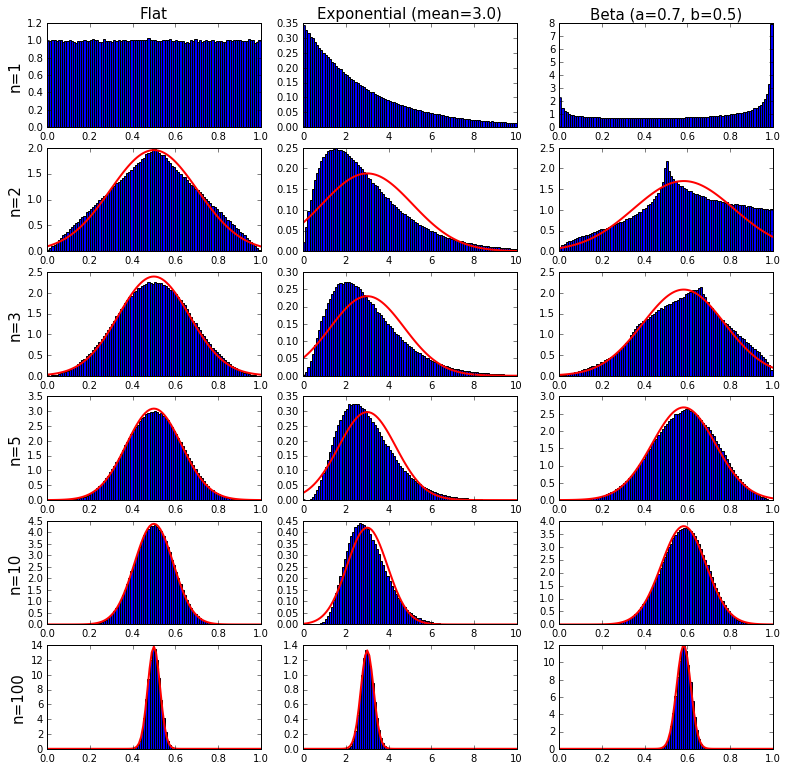

In [1]:
N=1000000 # number of times n samples are taken. Try varying this number.
nobb=101 # number of bin boundaries on plots
n=np.array([1,2,3,5,10,100]) # number of samples to average over

exp_mean=3 # mean of exponential distribution
a,b=0.7,0.5 # parameters of beta distribution

dist=[partial(np.random.random),partial(np.random.exponential,exp_mean),partial(np.random.beta,a,b)]
title_names=["Flat", "Exponential (mean=%.1f)" % exp_mean, "Beta (a=%.1f, b=%.1f)" % (a,b)]
drange=np.array([[0,1],[0,10],[0,1]]) # ranges of distributions
means=np.array([0.5,exp_mean,a/(a+b)]) # means of distributions
var=np.array([1/12,exp_mean**2,a*b/((a+b+1)*(a+b)**2)]) # variances of distributions

binrange=np.array([np.linspace(p,q,nobb) for p,q in drange])
ln,ld=len(n),len(dist)
plt.figure(figsize=((ld*4)+1,(ln*2)+1))

for i in range(ln): # loop over number of n samples to average over
    for j in range(ld): # loop over the different distributions
        plt.subplot(ln,ld,i*ld+1+j)
        plt.hist(np.mean(dist[j]((N,n[i])),1),binrange[j],normed=True)
        plt.xlim(drange[j])
        if j==0:
            plt.ylabel('n=%i' % n[i],fontsize=15)        
        if i==0:
            plt.title(title_names[j], fontsize=15)
        else:
            clt=(1/(np.sqrt(2*np.pi*var[j]/n[i])))*np.exp(-(((binrange[j]-means[j])**2)*n[i]/(2*var[j])))
            plt.plot(binrange[j],clt,'r',linewidth=2)     
plt.show()

In the graphs above the red curve is the predicted Gaussian distribution from the Central Limit Thereom. Notice that the rate of convergence of the sample mean to the Gaussian depends on the original parent distribution. Also, 

- the mean of the Gaussian distribution is the same as the original parent distribution,
- the width of the Gaussian distribution scales as $1/\sqrt{n}$.

To finish a quick round on frequentist view on machine learning:

- Estimator is a function of the data: $\hat\theta = g(\mathcal{D})$ where $\mathcal{D} = {X}_{1:n}$

its **BIAS** is:

$BIAS(\hat\theta) = E_{p(\mathcal{D} \rvert \theta_{0})} (\hat\theta) - \theta_{0} = \overline\theta - \theta_{0}$ or the difference between the mean of the $\theta s$ you have estimated and the $\theta_{0}$. If you are sampling data from a true distribution and you are averaging all the possible estimators, bias is essentially how far off you are on average.

**VARIANCE** 

$\mathcal{V}(\hat\theta) = E_{p}(D \rvert \theta_{0}) (\hat\theta - \bar\theta)^2$

Another error component that is due to to oscillation. Ideally you wold have a model with 0 bias and 0 variance but models will always have a trade-off. Models with high variance that -if averaged- will give you spot on bias are the Random Forests f.i.

# Regularization

One problem with Least Squares is that it requires to invert a matrix. All the answers so far were of the form: $\hat\theta = (X^TX)^{-1}X^T Y$ so the matrix with form $\mathcal{D} x \mathcal{D}$ that you are inverting is often poorly conditioned. N could have 20 patients and D could be 20000 genes so you end up with a matrix 20K x 20K but you only had 20 data points so logically you run into trouble inverting the matrix. There is a hack: adding 0's to the diagonal (or small elements) that stabilizes everything. 

$\hat\theta = (X^TX + \delta^{2}I_{d})^{-1} X^TY$

This hack turns out to be statistically very sound and dominates the MLE in high-dimensions. This is actually the solution to the so-called **penalized maximum likelihood**

$J(\theta) = (y - X\theta)^T (y-X\theta) + \delta^{2}\theta^T\theta$ where $\delta^{2}\theta^T\theta$ is the penalty regularizer. We are adding to the cost an extra term: in essence this is a **ridge regression estimate**. Now you have to minimize 2 things: line needs to fit the points but you also need to make $\theta$ small. This will make the model more stable but also give better predictions (partly because we have less influence of outliers. 

**derivation**

The derivative of J with respect to $\theta$: 

$\frac{\partial \mathcal{J(\theta)}}{\partial \theta} = 2X^TX\theta-2X^Ty+2\delta^{2}I\theta$

equate to 0:

$(X^TX + \delta^{2} I)\theta = X^TY$



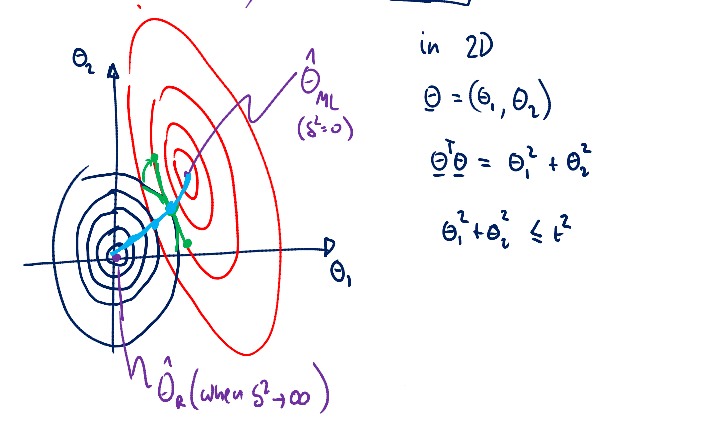

In [6]:
Image(PATH + 'ridge_regularization.png')

Big question is how to guess $\delta^{2}$. The geometric view in @D is as follows:

> $J(\theta) = \underset{a}(y-X\theta)^T(y-X\theta) + \underset{b}\delta^{2}\theta^T\theta$ where you can plot the first 2 elements as ellipses. 

> $\underset{d}\theta: \theta^T\theta <= t(\delta) \hspace{2mm}\underset{c}\{(y-X\theta)^T (y-X\theta)\}$


Let's say the vector $\theta$ has 2 components: $(\theta_{1}$ and $\theta_{2})$ so that 

$\theta^T \theta = \theta_{1}^{2} + \theta_{2}^{2}$

for now we argue that if we want to minimize the 2 terms A + B, it's the same as as minimizing the first term on the right (C) and allowing the second term on the right $(d) - t{\delta}$ to be small.

We know what happens to the extremes: when $\delta$ is very small or when it is very large. question is what happens in between? The solutions are points at which the 2 contour plots are overlapping and since the gradient is always perpendicular to the contour plot, it'll be 2 points at which the 2 gradients are collinear. So by moving along the contour, the (real) cost hasn't changed but the (blue) cost has increased. Optimal points $*$, applied to any argument of delta, show in the curve. This curve is essential in picking variables. 

What is also important to notify is that some $\theta$ s will go to 0 faster than others because the curve is sort of bent, a fact that'll be exploited later on. F.i. if you have 20K genes, and each gene scaled by a $\theta$, and most genes divided by $\theta$ go to zero, only the responsible remaining genes will than be correlated with what happens to the patient.

In [14]:
(np.arange(1, p+1) + np.arange(0, n)[:, np.newaxis])

array([[ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10],
       [ 2,  3,  4,  5,  6,  7,  8,  9, 10, 11],
       [ 3,  4,  5,  6,  7,  8,  9, 10, 11, 12],
       [ 4,  5,  6,  7,  8,  9, 10, 11, 12, 13],
       [ 5,  6,  7,  8,  9, 10, 11, 12, 13, 14],
       [ 6,  7,  8,  9, 10, 11, 12, 13, 14, 15],
       [ 7,  8,  9, 10, 11, 12, 13, 14, 15, 16],
       [ 8,  9, 10, 11, 12, 13, 14, 15, 16, 17],
       [ 9, 10, 11, 12, 13, 14, 15, 16, 17, 18],
       [10, 11, 12, 13, 14, 15, 16, 17, 18, 19],
       [11, 12, 13, 14, 15, 16, 17, 18, 19, 20],
       [12, 13, 14, 15, 16, 17, 18, 19, 20, 21],
       [13, 14, 15, 16, 17, 18, 19, 20, 21, 22],
       [14, 15, 16, 17, 18, 19, 20, 21, 22, 23],
       [15, 16, 17, 18, 19, 20, 21, 22, 23, 24],
       [16, 17, 18, 19, 20, 21, 22, 23, 24, 25],
       [17, 18, 19, 20, 21, 22, 23, 24, 25, 26],
       [18, 19, 20, 21, 22, 23, 24, 25, 26, 27],
       [19, 20, 21, 22, 23, 24, 25, 26, 27, 28],
       [20, 21, 22, 23, 24, 25, 26, 27, 28, 29]])


Ridge coefficients as a function of the regularization parameter
----------------------------------------------------------------
And highlight in dashed lines the optimal value by cross-validation.
Source: http://fa.bianp.net/blog/2011/ridge-regression-path/



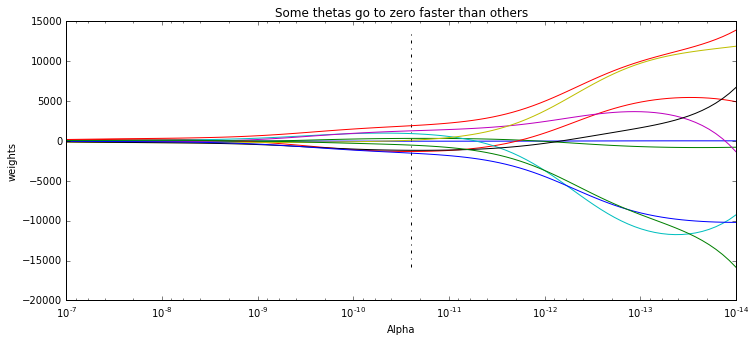

In [25]:
from scipy import linalg
from sklearn import linear_model

"""
Ridge coefficients as a function of the regularization parameter
----------------------------------------------------------------
And highlight in dashed lines the optimal value by cross-validation.
Source: http://fa.bianp.net/blog/2011/ridge-regression-path/
"""
print (__doc__)

# .. Local variables ..
n, p = 20, 10
X = 1. / (np.arange(1, p+1) + np.arange(0, n)[:, np.newaxis])
y = np.ones(n)
n_alphas = 100
alphas = np.logspace(-14, -7, n_alphas)
 
# .. Ridge path using an SVD ..
U, s, Vt = linalg.svd(X, full_matrices=False)
d = s / (s[:, np.newaxis].T ** 2 + alphas[:, np.newaxis])
Uy = U.T.dot(y)
coefs = np.dot(d * U.T.dot(y), Vt)
 
# ..
# .. Best cross-validation score ..
ridge_cv = linear_model.RidgeCV(alphas=alphas, fit_intercept=False)
ridge_cv.fit(X, y)
 
# ..
# .. Display results ..
fig, ax = plt.subplots(1,1, figsize = [12,5])
ax.vlines(ridge_cv.alpha_, np.min(coefs), np.max(coefs), linestyle='dashdot')
ax.plot(alphas, coefs)
ax.set(xscale = 'log', xlabel = 'Alpha', ylabel = 'weights', 
       title ='Some thetas go to zero faster than others')
ax.set_xlim(ax.get_xlim()[::-1]) # reverse axis
#plt.axis('tight')
plt.show()

Ridge coefficients for multiple values of the regularization parameter can be elegantly computed by updating the thin SVD decomposition of the design matrix. This can be used to efficiently compute what it's regularization path, that is, to plot the coefficients as a function of the regularization parameter.

In [28]:
# Source: http://fa.bianp.net/blog/2011/ridge-regression-path/

def ridge(A, b, alphas):
    """
    Return coefficients for regularized least squares

         min ||A x - b||^2 + alpha ||x||^2

    Parameters
    ----------
    A : array, shape (n, p)
    b : array, shape (n,)
    alphas : array, shape (k,)

    Returns
    -------
    coef: array, shape (p, k)
    """
    U, s, Vt = linalg.svd(X, full_matrices=False)
    d = s / (s[:, np.newaxis].T ** 2 + alphas[:, np.newaxis])
    return np.dot(d * U.T.dot(y), Vt).T

### Going non-linear

Some basis functions still apply. The easiest way to move to non-linear is to construct a so-called basis function $\phi (.)$ which can be -at it's simplest form- a polynomial f.i. $X^2$. F.i here we have data X, we add a 1, so we can shift the curve up and down, but we also have our data that we can square. $\phi(X) = [1, x, x^{2}]$

In [92]:
# slightly modifief code from 
# https://github.com/jakevdp/PythonDataScienceHandbook/blob/master/notebooks/05.03-Hyperparameters-and-Model-Validation.ipynb

def make_data(N, err=1.0, rseed=1):
    # randomly sample the data
    rng = np.random.RandomState(rseed)
    X = rng.rand(N, 1) ** 2
    y = 10 - 1. / (X.ravel() + 0.1)
    if err > 0:
        y += err * rng.randn(N)
    return X, y

X, y = make_data(40)

In [93]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import make_pipeline

def PolynomialRegression(degree=2, **kwargs):
    return make_pipeline(PolynomialFeatures(degree),
                         LinearRegression(**kwargs))

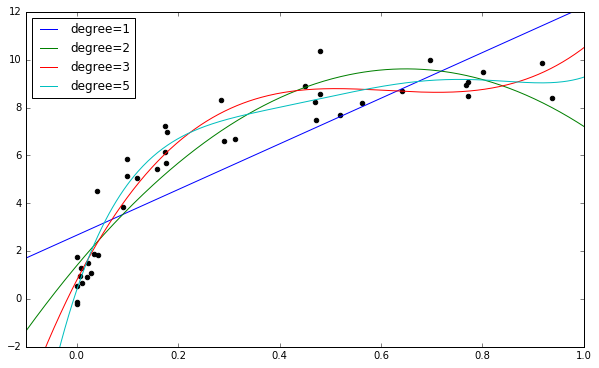

In [94]:
X_test = np.linspace(-0.1, 1.1, 500)[:, None]

fig, ax = plt.subplots(figsize= [10,6])
ax.scatter(X.ravel(), y, color='black')
for degree in [1, 2, 3, 5]:
    y_test = PolynomialRegression(degree).fit(X, y).predict(X_test)
    ax.plot(X_test.ravel(), y_test, label='degree={0}'.format(degree))
ax.set(xlim = (-0.1, 1.0), ylim = (-2, 12))
ax.legend(loc='best');

With polynomials, we still have something that is linear. In degree 2 (a second degree Polynomial) we added $X^2$ and now we can fit the data that has quadratic trends. the Maximum Likelihood answer is then: 

$\hat\theta_{ml} = {\big[\phi(x)^T\phi(x)\big]}^{-1} \phi x^TY$ and is basically the same trick. We can also introduce a ridge regularizer. 

The same trick applies if you go to more dimensions:

$\phi (x) = \big[ 1, x_{1}, x_{2}, x_{1}^2, x_{2}^2 \big]$


Example: Ridge regression with a polynomial of degree 14:

$\hat y (x_{i}) = 1\theta_{0} + x_{i}\theta_{1} + x_{i}^2\theta_{2} + .. + x_{i}^{13}\theta_{13} + x_{i}^{14}\theta_{14}$

$\phi = \big[ 1 x_{i} x_{i}^{2} ... x_{i}^{13} x_{i}^{14} \big]$

$J(\theta) = (y - \phi\theta)^T (y-\phi\theta) + \delta^{2}\theta^T\theta$

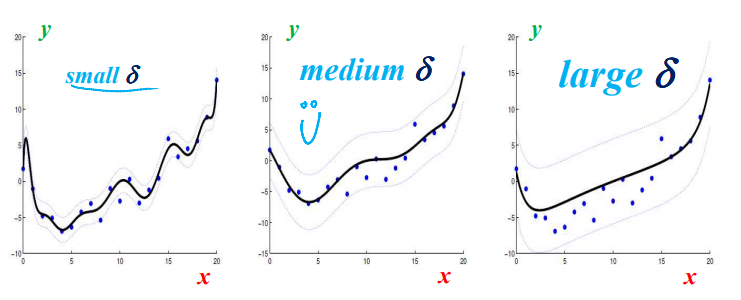

In [67]:
Image(PATH + 'ridge_regularization2.png')

If you go to higher powers, the polynomial will become much more flexible. But how much should I raise my polynomial? More degrees will only make the line more wigglier but by adding a regularizer with a sufficiently large $\delta$, we are forcing some of the $\theta s$ to go to 0 so if one of the terms goes to 0 f.i $x^{2}$, it gets rid of the second degree of the polynomial. Discovering the regularizers will. Task is to learn these regularizers from data.

### Kernel regression and RBFs

We can use kernels or **radial basis functions (RBFs)** as features (very popular in graphics and numerical computation). Basic idea is to put a RBF/kernel in some location. Think of RBFs as bricks to build larger functions just by plugging in the operations of scaling, multiplying by $\theta$ and addition. 

$\phi(x_{i}) = \big[1 \hspace{1mm} \mathcal{K}(X, \mu_{1}\lambda), ... \mathcal{K}(X, \mu_{d}\lambda)\big]$

$\hat Y(x_{i}) = \phi(x_{i}) \theta = 1\theta_{0} + \mathcal{K}(X_{i}, \mu_{1}\lambda)\theta_{1} + ... + \mathcal{K}(X_{1}, \mu_{d}\lambda)\theta_{d}$

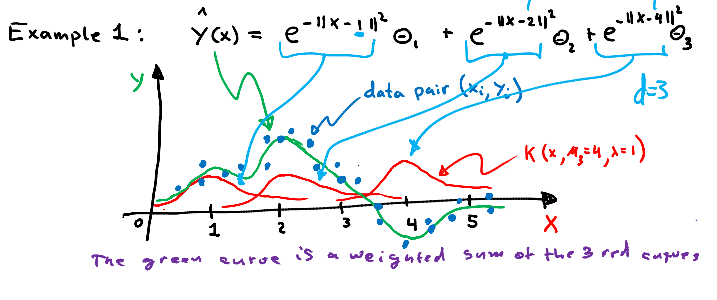

In [98]:
Image(PATH + 'kernel_regression.png')

Here $\phi(x_{i})$ is a vector with 4 entries. There are 3 bases. The corresponding vector of parameters is: $\underline \theta = \big[\theta_{0} \hspace{2mm}\theta_{1} \hspace{2mm}\theta_{2} \hspace{2mm}\theta_{3}\big]$ so 

$\hat Y = \phi (x_{i}) \hspace{1mm}\underline\theta$

If we have i=1 , ..., N data, let :

$\hat{y} = \left[ \begin{array}{cccc}
Y_{1} \\ Y_{2} \\ .. \\ Y_{n} \\\end{array} \right]$
$\phi = \left[ \begin{array}{cccc}
\phi(x_{1}) \\ \phi(x_{2}) \\ .. \\ \phi(x_{n}) \\\end{array} \right]$ 

Then:

$\hat Y = \phi \theta$

and:

$\hat \theta_{ls} = \big(\phi^T \phi\big)^{-1} \phi^T Y$

$\hat \theta_{ridge} = \big(\phi^T \phi + \delta^{2} \mathcal{I}\big)^{-1} \phi^T Y$

Hence this is still linear regression with X replaced by $\phi$

Now we still need to figure out **where** to put those basis functions. We can put hem all where there are data points but it still leaves open the question what the width should be of the bases ($\lambda$ =  lambda will describe this width). This is tricky as illustrated: 

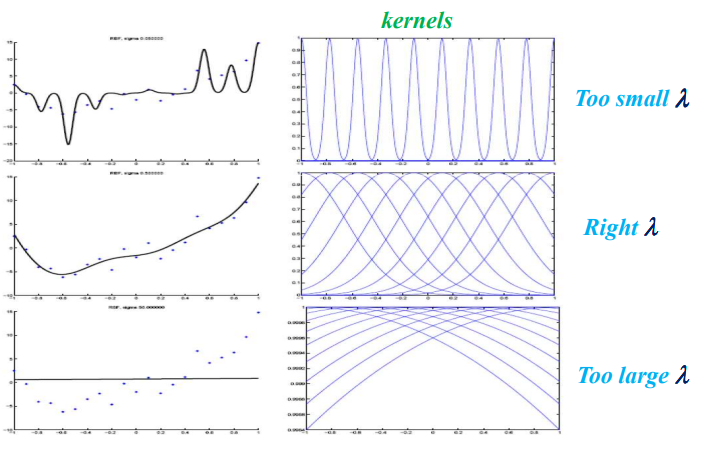

In [99]:
Image(PATH + 'kernel_lambda.png')

The top Lambda is very narrow and we choose that width, the fit on the data would show like on the top-left picture. The big question is how do we choose the regularization coefficient, the width of the kernels or the polynomial order? One solution is **cross-validation**

Example) Using **validation_curve**, given a model, data, parameter name, and a range to explore, this function will automatically compute both the training score and validation score across the range. we see that the optimal trade-off between bias and variance is found for a third-order polynomial: 

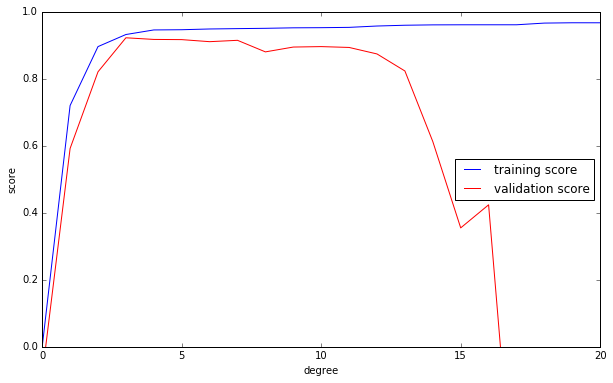

In [97]:
from sklearn.learning_curve import validation_curve
degree = np.arange(0, 21) # 0 -21-order polynomials
train_score, val_score = validation_curve(PolynomialRegression(), X, y,
                                          'polynomialfeatures__degree', degree, cv=7)

fig,ax = plt.subplots(figsize= [10,6])
ax.plot(degree, np.median(train_score, 1), color='blue', label='training score')
ax.plot(degree, np.median(val_score, 1), color='red', label='validation score')
ax.set(ylim = (0, 1), xlabel = ('degree'), ylabel = ('score')); ax.legend(loc='best');

Shortcomings of cross-validation (CV) is that you must choose 'guesses' of $\delta$. This can be solved with Gaussian processes and Bayesian optimization. If it becomes combinatorial $(\delta + \lambda)$, you also need to take all possible combinations into account. 

Other techniques are k-fold CV: splitting data into K-folds, then for each $\mathcal{K} \in \{ 1, .., K \}$, we train on all folds but the k'th and test on the k'th. 

If we set K = N, then we get a method called **leave-one out cross validation or LOOCV**, since in fold i, we train on all data cases except for i, and then test on i.

## Other exercise to show cross validation and overfitting 

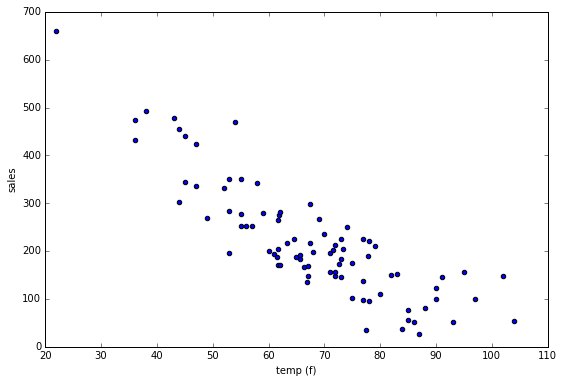

In [4]:
df = pd.DataFrame({
    'temp': [22, 36, 36, 38, 44, 45, 47, 43, 44, 45, 47, 49,
             52, 53, 53, 53, 54, 55, 55, 55, 56, 57, 58, 59,
             60, 61, 61.5, 61.7, 61.7, 61.7, 61.8, 62, 62, 63.4, 64.6,
             65, 65.6, 65.6, 66.4, 66.9, 67, 67, 67.4, 67.5, 68, 69, 
             70, 71, 71, 71.5, 72, 72, 72, 72.7, 73, 73, 73, 73.3, 74, 75, 75, 
             77, 77, 77, 77.4, 77.9, 78, 78, 79, 80, 82, 83, 84, 85, 85, 86, 87, 88,
             90, 90, 91, 93, 95, 97, 102, 104],
    'sales': [660, 433, 475, 492, 302, 345, 337, 479, 456, 440, 423, 269,
              331, 197, 283, 351, 470, 252, 278, 350, 253, 253, 343, 280,
              200, 194, 188, 171, 204, 266, 275, 171, 282, 218, 226, 
              187, 184, 192, 167, 136, 149, 168, 218, 298, 199, 268,
              235, 157, 196, 203, 148, 157, 213, 173, 145, 184, 226, 204, 250, 102, 176,
              97, 138, 226, 35, 190, 221, 95, 211,110, 150, 152, 37, 76, 56, 51, 27, 82,
              100, 123, 145, 51, 156, 99, 147, 54]})
fig,ax = plt.subplots(figsize=[9,6])
ax.scatter(df['temp'], df['sales'], c = 'blue')
ax.set(xlabel='temp (f)', ylabel='sales', xlim =[20,110], ylim =[0,700]);

In [5]:
def rmse(predictions, targets):
    """calc the Root-mean-Square-Error"""
    return np.sqrt(((predictions - targets)**2).mean())

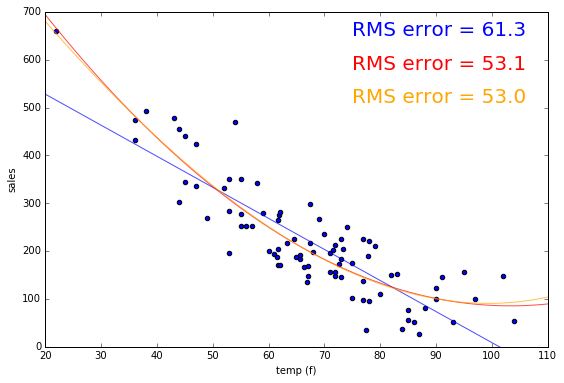

In [6]:
fig, ax = plt.subplots(figsize=[9,6])

ax.scatter(df['temp'], df['sales'], c = 'blue')
ax.set(xlabel='temp (f)', ylabel='sales', xlim =[20,110], ylim =[0,700]);

# 1D Polynomial Fit
poly1 = np.poly1d(np.polyfit(df['temp'], df['sales'], 1))
poly1_predictions = poly1(range(111))
ax.plot(range(111), poly1_predictions, color ='blue', alpha= .7)

# 2D Polynomial Fit
poly2 = np.poly1d(np.polyfit(df['temp'], df['sales'], 2))
poly2_predictions = poly2(range(111))
ax.plot(range(111), poly2_predictions, color ='red', alpha= .7)

# 3D Polynomial Fit
poly3 = np.poly1d(np.polyfit(df['temp'], df['sales'], 3))
poly3_predictions = poly3(range(111))
ax.plot(range(111), poly3_predictions, color ='orange', alpha= .7)

ax.annotate('RMS error = %2.1f' % rmse(poly1(df.temp), df.sales),
             xy=(75, 650), fontsize=20, color='blue', backgroundcolor='w')
ax.annotate('RMS error = %2.1f' % rmse(poly2(df.temp), df.sales),
             xy=(75, 580), fontsize=20, color='red', backgroundcolor='w')
ax.annotate('RMS error = %2.1f' % rmse(poly3(df.temp), df.sales),
             xy=(75, 510), fontsize=20, color='orange', backgroundcolor='w')

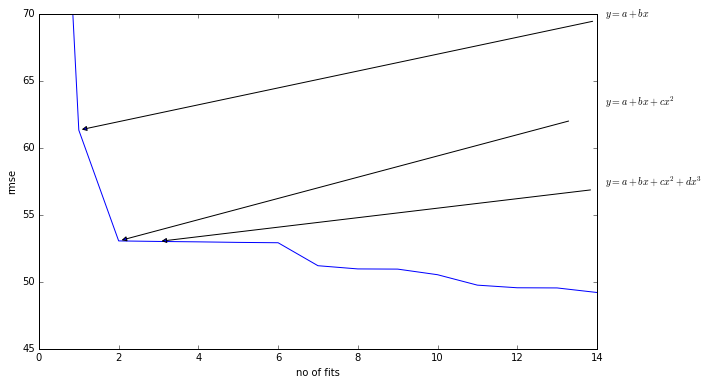

In [7]:
#  is this the best possible model that we can find?
fig, ax = plt.subplots(figsize=[10,6])

rmse_multi = []
for i in range(15):
    model = np.poly1d(np.polyfit(df['temp'], df['sales'], i))
    predictions = model(df['temp'])
    rmse_multi.append(rmse(predictions, df['sales']))

ax.plot(range(15), rmse_multi)
ax.set(xlabel = 'no of fits', ylabel ='rmse', ylim = [45,70])

plt.annotate('$y = a + bx$', xytext=(14.2, 70), xy=(1, rmse_multi[1]), multialignment='right',
             va='center', 
             arrowprops={'arrowstyle': '-|>', 'lw': 1, 'shrinkA': 10, 'shrinkB': 3})

plt.annotate('$y = a + bx + cx^2$', xytext=(14.2, 64), xy=(2, rmse_multi[2]), multialignment='right',
             va='top', 
             arrowprops={'arrowstyle': '-|>', 'lw': 1, 'shrinkA': 35, 'shrinkB': 3})


plt.annotate('$y = a + bx + cx^2 + dx^3$', xytext=(14.2, 58), xy=(3, rmse_multi[3]), 
             multialignment='right', va='top',
             arrowprops={'arrowstyle': '-|>', 'lw': 1,'shrinkA': 12, 'shrinkB': 3});

Off course we would run into **overfitting** when ,catching the data too closely. Cross Validation is needed.

In [19]:
df1 = df.sample(int(len(df)/2))
df2 = df.drop(df1.index)

RMSE average = 56.0


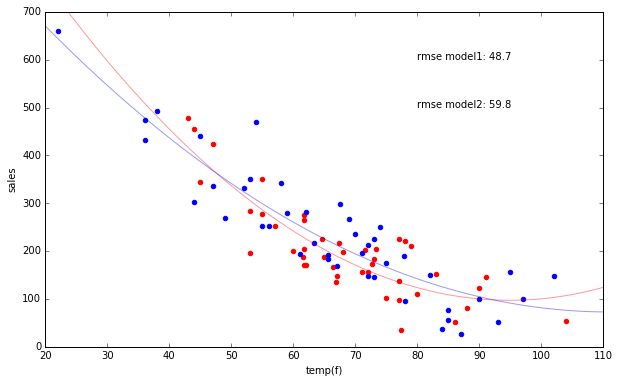

In [20]:
fig, ax = plt.subplots(figsize= [10,6])

model1 = np.poly1d(np.polyfit(df1['temp'], df1['sales'], 2))
model2 = np.poly1d(np.polyfit(df2['temp'], df2['sales'], 2))

x_min, x_max = 20, 110
y_min, y_max = 0, 700
x = range(x_min, x_max + 1)

ax.scatter(df1['temp'], df1['sales'], color= 'red')
ax.scatter(df2['temp'], df2['sales'], color= 'blue')
ax.plot(x, model1(x), color ='red', alpha =.4)
ax.plot(x, model2(x), color ='blue', alpha =.4)
ax.annotate('rmse model1: %2.1f' % rmse(model1(df1['temp']), df1['sales']), xy = (80,600))
ax.annotate('rmse model2: %2.1f' % rmse(model1(df2['temp']), df2['sales']), xy = (80,500))
ax.set(xlim =[x_min,x_max], ylim =[y_min,y_max], xlabel = 'temp(f)', ylabel= 'sales');

# so average the 2 RMSE scores
print ('RMSE average = %2.1f' % np.mean([rmse(model1(df2['temp']), df2['sales']),
                                        rmse(model2(df1['temp']), df1['sales'])
                                       ]))

C:\Users\Schiphol\Anaconda3\lib\site-packages\ipykernel\__main__.py:9: RankWarning: Polyfit may be poorly conditioned


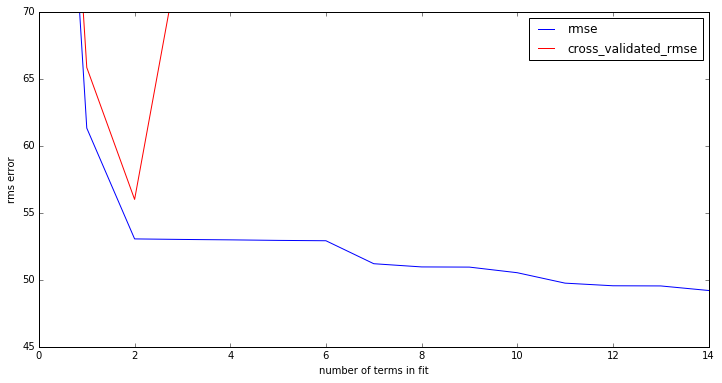

In [21]:
fig, ax = plt.subplots(figsize=[12,6])
rmse_multi = []
cross_validated_rmse = []
for i in range(15):
    model = np.poly1d(np.polyfit(df['temp'], df['sales'], i))
    predictions = model(df['temp'])
    rmse_multi.append(rmse(predictions, df['sales']))
    # use cross validation
    model1 = np.poly1d(np.polyfit(df1['temp'], df1['sales'], i))
    model2 = np.poly1d(np.polyfit(df2['temp'], df2['sales'], i))

    p1 = model1(df2['temp'])
    p2 = model2(df1['temp'])
    
    cross_validated_rmse.append(np.mean([rmse(p1, df2['sales']),
                                        rmse(p2, df1['sales'])]))
    
ax.plot(range(15), rmse_multi, color ='blue', label ='rmse')
ax.plot(range(15), cross_validated_rmse, color ='red', label ='cross_validated_rmse')
ax.set(ylim = [45,70], xlabel = 'number of terms in fit', ylabel ='rms error')
ax.legend(frameon = True)

Going from a 1-deg to a 2-deg polynomial fit gives us quite a large improvement overall. But, unlike the RMSE that we calculated against the training set, when using cross-validation we can see that adding more degrees of freedom to our equation quickly reduces the effectiveness of the model against unseen data. This is overfitting in action! 